In [1]:
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
import numpy as np
from scipy.stats import chi2_contingency
from math import sqrt

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

Overall, there's **quite a number of missing values in both training and validation sets**, as well as a mixture of numerical and categorical columns. Some early observations:

- The column `v16` has the largest number of missing rows (>50%).
- The `classLabel` column is our binary target variable

When dealing with null values we usually consider domain knowledge. This can determine whether we forward fill, impute the values with their mode, or drop the column entirely. However, since we don't know what these columns represent, **what method of imputation** (or dropping the columns entirely) used **will mainly be decided by our exploration of the dataset's underlying distributions**.

In [2]:
df_train = pd.read_csv('../data/training2.csv')
df_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,17.920,0.000,u,-0.840,0.523,1.750,f,t,1,t,g,80.000,5,800000.000,t,0,no.
1,b,16.920,0.000,y,-2.160,0.774,0.290,f,f,0,f,s,200.000,0,2000000.000,NaN,0,no.
2,b,31.250,0.000,u,1.751,0.760,0.000,f,t,1,f,g,96.000,19,960000.000,t,0,no.


In [5]:
print(f"Shape of train dataset: {df_train.shape}")
print("")
df_train.info()

Shape of train dataset: (3700, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          3661 non-null   object 
 1   v2          3661 non-null   float64
 2   v3          3700 non-null   float64
 3   v4          3636 non-null   object 
 4   v5          3700 non-null   float64
 5   v6          3700 non-null   float64
 6   v7          3700 non-null   float64
 7   v8          3700 non-null   object 
 8   v9          3700 non-null   object 
 9   v10         3700 non-null   int64  
 10  v11         3700 non-null   object 
 11  v12         3700 non-null   object 
 12  v13         3600 non-null   float64
 13  v14         3700 non-null   int64  
 14  v15         3600 non-null   float64
 15  v16         1555 non-null   object 
 16  v17         3700 non-null   int64  
 17  classLabel  3700 non-null   object 
dtypes: float64(7), int64(3), object(

In [3]:
df_val = pd.read_csv('../data/validation2.csv')
df_val.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,b,32.330,0.001,u,0.840,0.545,1.585,t,f,0,t,s,420.000,0,4200000.000,NaN,1,no.
1,b,23.580,0.000,u,-4.174,0.864,0.540,f,f,0,t,g,136.000,1,1360000.000,NaN,0,no.
2,b,36.420,0.000,y,2.232,0.627,0.585,f,f,0,f,g,240.000,3,2400000.000,NaN,1,no.


In [7]:
print(f"Shape of validation dataset: {df_val.shape}")
print("")
df_val.info()

Shape of validation dataset: (200, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          197 non-null    object 
 1   v2          197 non-null    float64
 2   v3          200 non-null    float64
 3   v4          198 non-null    object 
 4   v5          200 non-null    float64
 5   v6          200 non-null    float64
 6   v7          200 non-null    float64
 7   v8          200 non-null    object 
 8   v9          200 non-null    object 
 9   v10         200 non-null    int64  
 10  v11         200 non-null    object 
 11  v12         200 non-null    object 
 12  v13         197 non-null    float64
 13  v14         200 non-null    int64  
 14  v15         197 non-null    float64
 15  v16         89 non-null     object 
 16  v17         200 non-null    int64  
 17  classLabel  200 non-null    object 
dtypes: float64(7), int64(3), objec

#### **1.0 Check for duplicates**

A quick check for duplicates yield none.

In [4]:
# check for duplicates
len(df_train[df_train.duplicated(subset=None, keep=False)])

0

In [5]:
# check for duplicates
len(df_val[df_val.duplicated(subset=None, keep=False)])

0

#### **2.0 EDA on non-numerical columns**

In [4]:
# separate categorical & numerical columns for analyses
CatCols=['v1', 'v4', 'v8', 'v9', 'v11',
         'v12', 'v16', 'classLabel']
NumCols=list(set(df_train.columns)-set(CatCols))

We make note that `v4` and `v12` don't have the same number of unique values. In `v4` we find 3 unique values in `df_train` while we only have 2 in `df_val`. For `v12`, `df_train` has 3 unique values while `df_val` has 4. 

Upon closer inspection, **different values for** `v4` **(l) and** `v12` **(o) have very small occurences in the dataset (<1%)**. These features may naturally have high caridnality (and small rare categories), which can potentially lead to a noisy dataset. It can be difficult for an ML algorithm to cut through this noise and learn from the more meaningful signals in the data.

Hence, **later on, we'll employ binning** where we group multiple categories into a single category.

In [10]:
df_train[CatCols].describe()

,v1,v4,v8,v9,v11,v12,v16,classLabel
count,3661,3636,3700,3700,3700,3700,1555,3700
unique,2,3,2,2,2,3,2,2
top,b,u,t,t,f,g,t,yes.
freq,2382,3055,3171,2239,1924,3430,1023,3424


In [11]:
df_train['v4'].value_counts(normalize=True)

v4
u   0.840
y   0.151
l   0.009
Name: proportion, dtype: float64

In [12]:
df_train['v12'].value_counts(normalize=True)

v12
g   0.927
s   0.051
p   0.022
Name: proportion, dtype: float64

In [13]:
df_val[CatCols].describe()

,v1,v4,v8,v9,v11,v12,v16,classLabel
count,197,198,200,200,200,200,89,200
unique,2,2,2,2,2,4,2,2
top,b,u,t,f,t,g,f,no.
freq,141,149,115,104,100,180,48,107


In [14]:
df_val['v4'].value_counts(normalize=True)

v4
u   0.753
y   0.247
Name: proportion, dtype: float64

In [15]:
df_val['v12'].value_counts(normalize=True)

v12
g   0.900
s   0.085
p   0.010
o   0.005
Name: proportion, dtype: float64

Before we plot these to look at the differences in distribution, we'll convert the columns to the *category* data type (instead of *object*).

In [7]:
df_train[CatCols] = df_train[CatCols].apply(lambda x: x.astype('category'))

In [8]:
df_val[CatCols] = df_val[CatCols].apply(lambda x: x.astype('category'))

In [23]:
df_train['classLabel'].value_counts(normalize=True)

classLabel
yes.   0.925
no.    0.075
Name: proportion, dtype: float64

In terms of how each of the feature's distributions vary between the validation and training sets, we highlight a few notable ones:

- Feature `v8` is more imbalanced in `df_train` (*f* has a far smaller count in comparison to *t*) in comparison to `df_val`
- Feature `v9` is slightly more imbalanced in `df_train`, while it's relatively equal in `df_val`
- Feature `v16` is also slightly more imbalanced in `df_train`, while it's relatively equal in `df_val`
- Finally, `classLabel` is extremely imbalanced in `df_train` with the *.no* class being extremely small (7%)

Pertaining to the target feature `classLabel`, to help mitigate the effects of a large class imbalance I could use SMOTE or imblearn to ensure that the binary classification model is not biased towards the majority class which is the *yes.* class. Moreover, this poses a challenge when using plain accuracy as a metric to measure the performance of the model as a model with 97% accuracy here could just predict all the *yes.* classes correctly but get all the *no.* classes wrongly. 

Depending on the domain (which we don't know), this can be problematic. **False positives** (outcomes where a test or a model incorrectly identify something as positive or as belonging to a certain category when, in reality, it is negative or does not belong to that category). They can lead to the allocation of resources (time, money, personnel) for addressing issues that do not actually exist. For example, in medical testing, false positives may result in unnecessary follow-up tests, treatments, and emotional distress for patients. In business and industrial settings, false positives can lead to operational inefficiencies. For instance, false alarms in security systems can disrupt operations, leading to downtime and inconvenience.

On the other hand **False negatives** are instances where the model incorrectly predicted a negative outcome when it should have predicted a positive outcome. In security and safety-critical applications, such as detecting malware or identifying dangerous objects in airport security, false negatives can have severe consequences. Failing to detect a threat can compromise security and public safety. In business and customer service, false negatives can result in dissatisfied customers. For instance, if a customer's legitimate transaction is incorrectly flagged as fraudulent by a credit card fraud detection system, it can lead to inconvenience and frustration.

Hence, later on when we build the model, **performance metric/s that needs to be chosen needs to perform well enough on detecting the *yes.* classes as well as the *no.* classes and reduce the risk of false positives and false negatives from happening.** For this I will look at the F1-score as the performance metric.

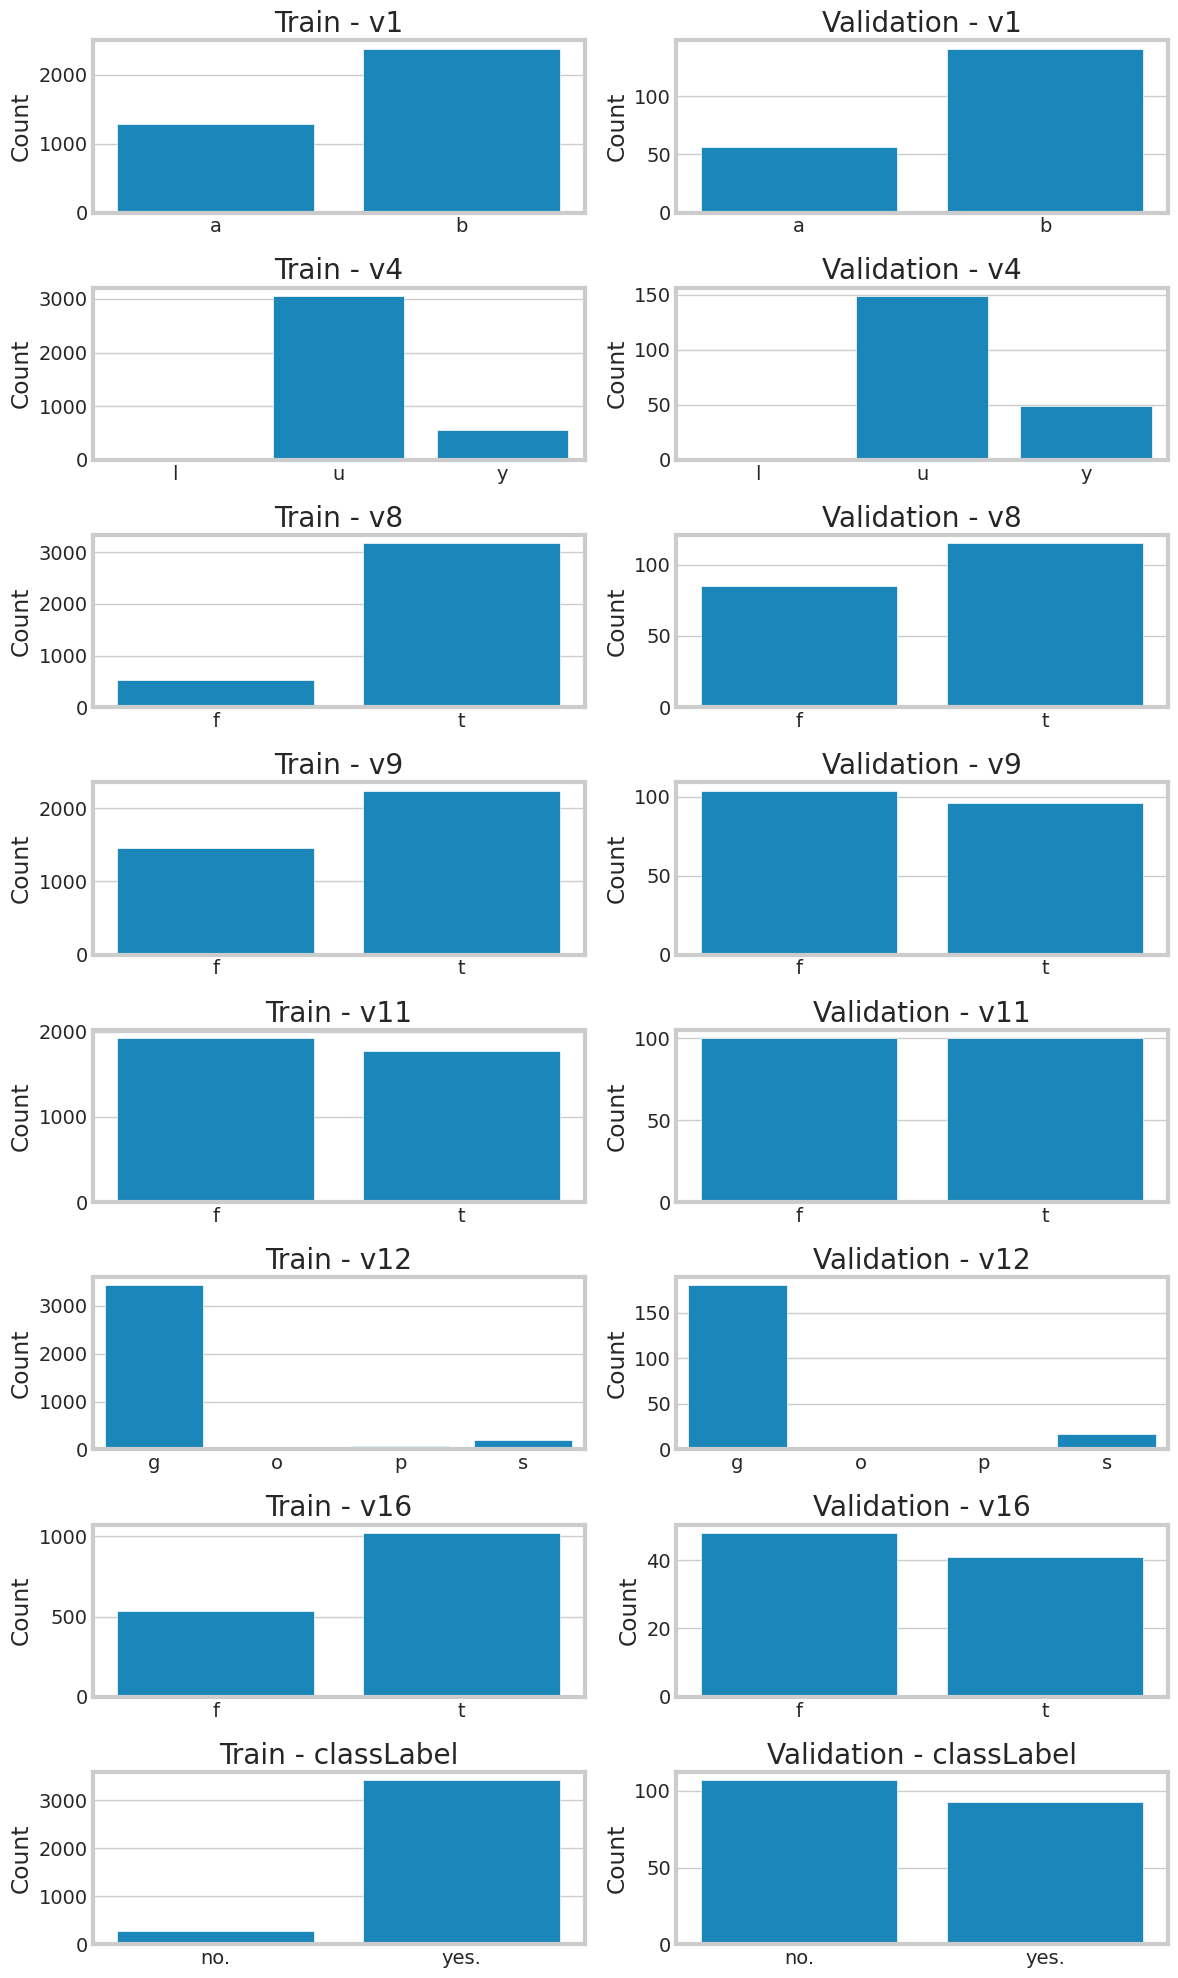

In [45]:
# Create subplots for each categorical column
fig, axs = plt.subplots(nrows=len(CatCols), ncols=2, figsize=(12, 20))

# Define a common order for categories based on the unique values in both dataframes
common_order = {}
for column in CatCols:
    unique_categories = sorted(
        set(df_train.loc[~df_train[column].isnull(), column].unique()) | \
        set(df_val.loc[~df_val[column].isnull(), column].unique()
    ))
    common_order[column] = unique_categories

for i, column in enumerate(CatCols):
    # Create a countplot for df_train
    sns.countplot(x=column, data=df_train[CatCols], ax=axs[i, 0], 
                  order=common_order[column])
    axs[i, 0].set_title(f'Train - {column}')
    
    # Create a countplot for df_val
    sns.countplot(x=column, data=df_val[CatCols], ax=axs[i, 1], 
                  order=common_order[column])
    axs[i, 1].set_title(f'Validation - {column}')

# Add labels and adjust the layout
for ax in axs.flat:
    ax.set_xlabel('')  # Remove x-axis label to save space
    ax.set_ylabel('Count')
plt.tight_layout()

# Show the plot
plt.show()

#### **3.0 EDA on numerical columns**

We make several observations:

- Feature `v17` behaves more discreetly then continously, with the `df_train` version being more imbalanced than `df_val`
- Feature `v6` is normally distributed in both dataframes, while feature `v5` is slightly uniformly distributed in `df_train`
- The rest of the features are positively skewed, with some features having outliers (as denoted by data points lying outside of the boxplot "whiskers")

Most of the continuous variables plotted here are positively skewed which means that I will need to normalize it to form a Normal Distribution. Depending on the modelling technique I would not need to normalize the data as some are more robust to outliers such as Decision Trees or if I were using gradient descent to fit a Neural Network then normalizing these values will help with convergence to a minima.

Pertaining to outliers, we'd also normally include domain knowledge to ascertain if the outlier value is an extreme rarity or data entry error. **Since we do not know what each individual feature represents, we wont be removing these and instead apply other methods to deal with outliers later on.**

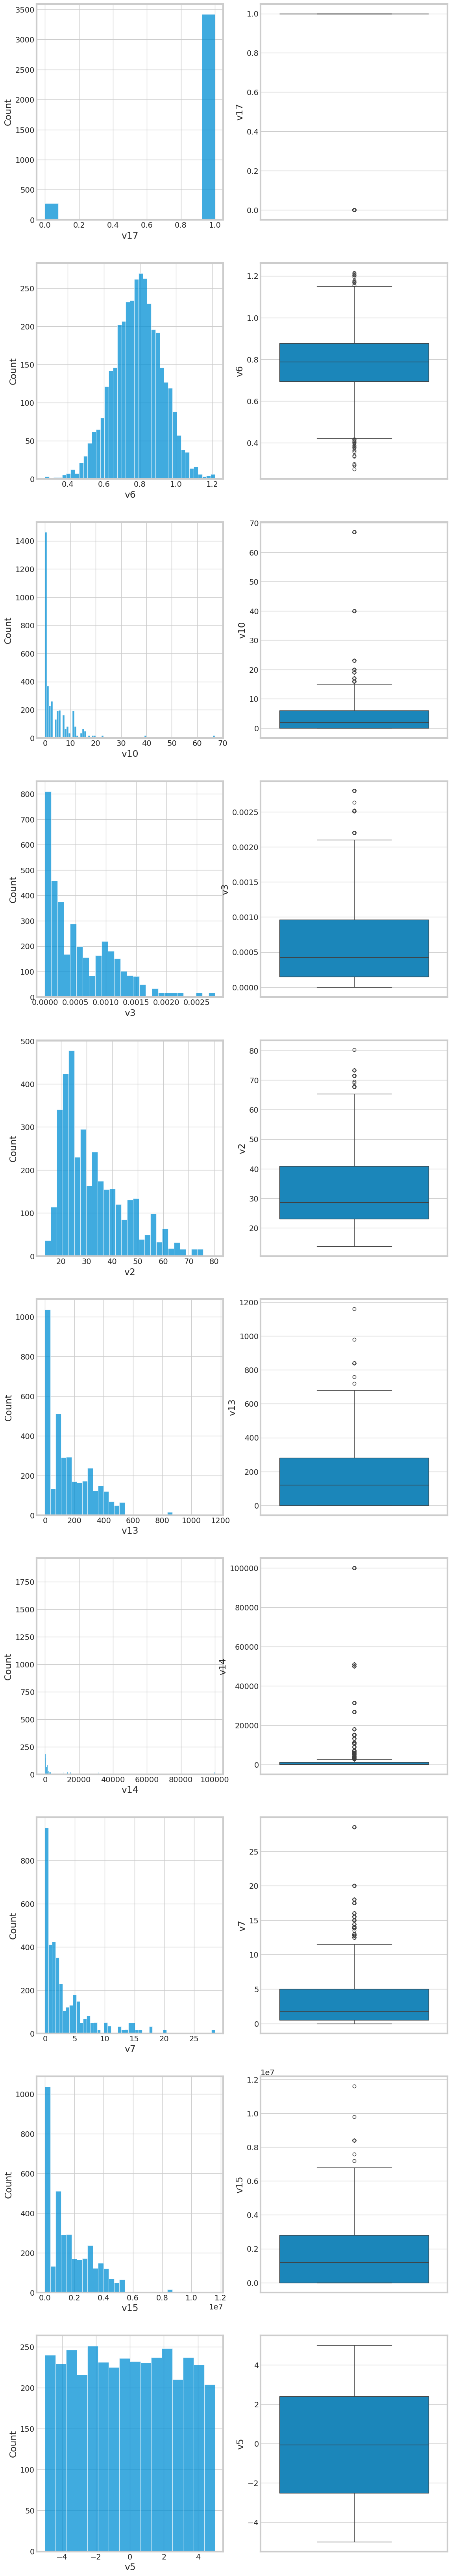

In [47]:
# charts for `df_train`
fig, ax=plt.subplots(nrows=len(NumCols), ncols=2, figsize=(12,80))
for i in range(len(NumCols)):
    sns.histplot(df_train[NumCols[i]],ax=ax[i,0])
    sns.boxplot(df_train[NumCols[i]],ax=ax[i,1]);

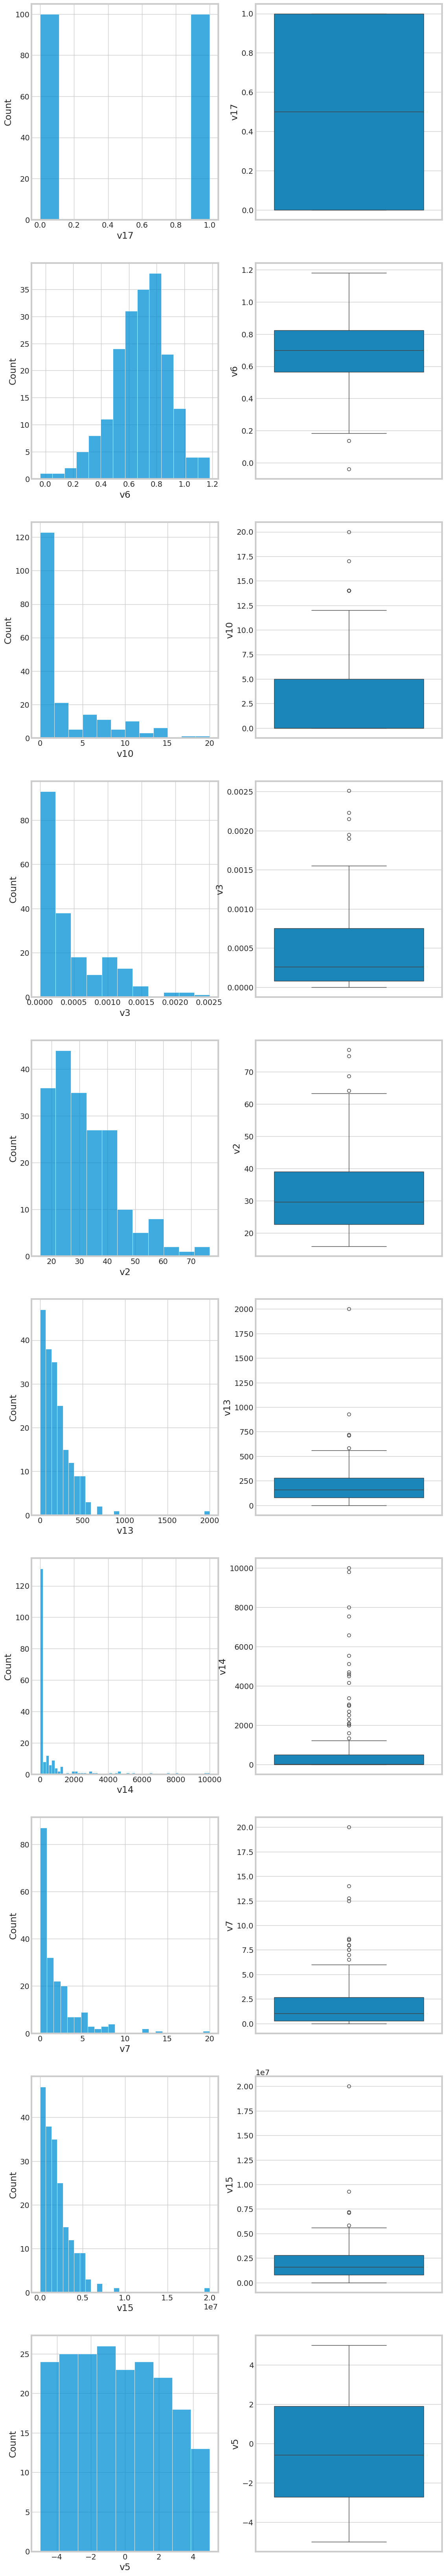

In [56]:
# charts for `df_val`
fig, ax=plt.subplots(nrows=len(NumCols), ncols=2, figsize=(12,80))
for i in range(len(NumCols)):
    sns.histplot(df_val[NumCols[i]],ax=ax[i,0])
    sns.boxplot(df_val[NumCols[i]],ax=ax[i,1]);

#### **4.0 Correlation between features in** `NumCols`

We need to be aware of highly correlated features due to multicollinearity. Multicollinearity makes it difficult to disentangle the individual effects of each correlated feature on the target variable. For example, in logistic regression, it can be challenging to estimate the contribution of each feature accurately because they are interrelated. This can result in unstable coefficient estimates.

We can glean that `v13` **&** `v15` **are perfectly correlated with one another**. Perfect correlation means that one feature is a linear combination of another, making them redundant. Hence, **since we don't know what the features represent, we'll proceed to randomly remove one of them later on**.

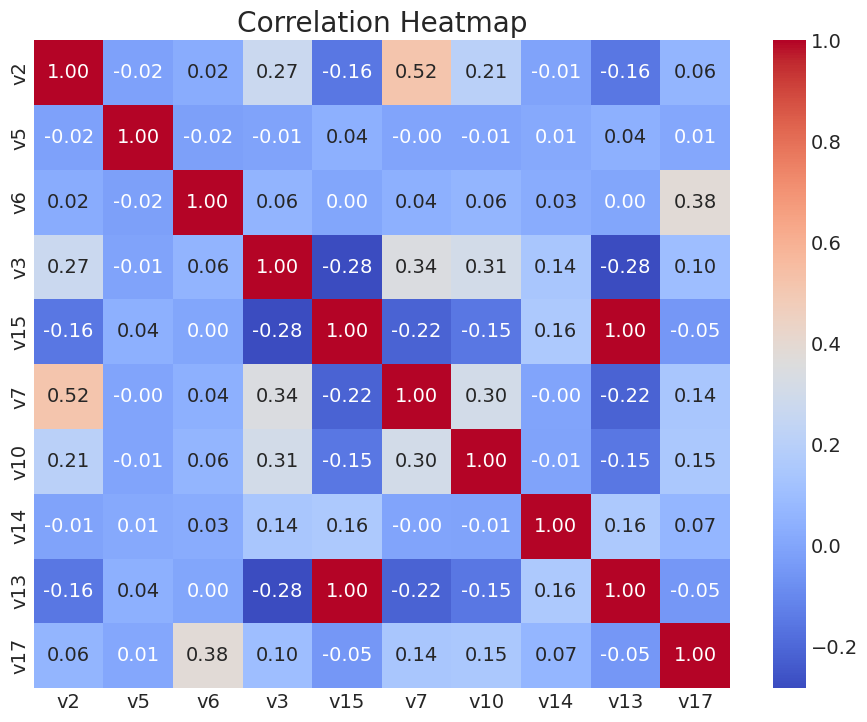

In [9]:
correlation_matrix_train = df_train[NumCols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

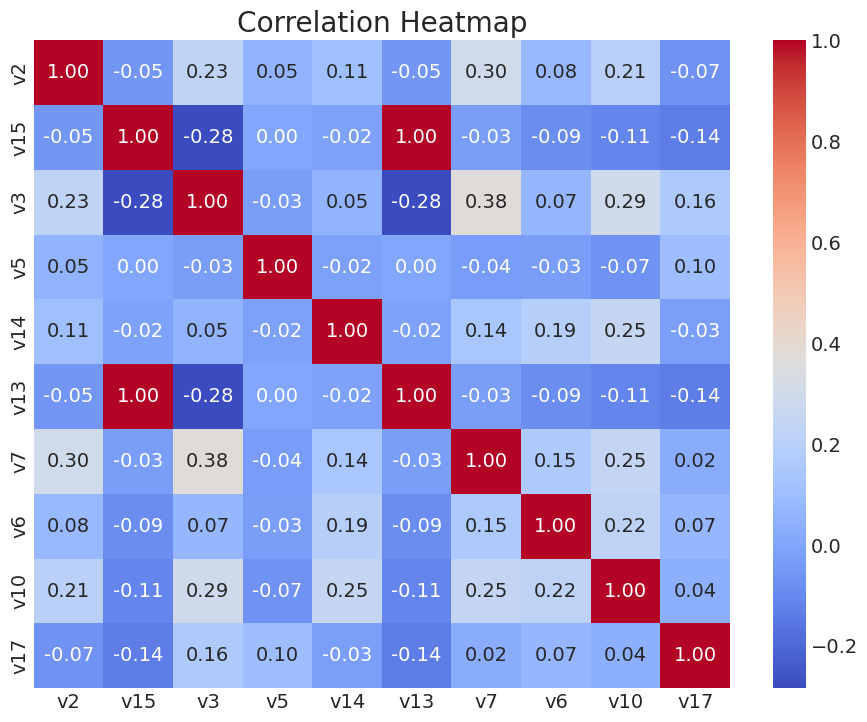

In [6]:
correlation_matrix_val = df_val[NumCols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_val, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### **5.0 Correlation between Categorical/Nominal columns with Target**

To assess this, we'll be using Cramer's V, which is a measure of association between two categorical variables, and it's based on the chi-squared statistic. Cramer’s V lies between 0 and 1 (inclusive). 0 indicates that the two variables are not linked by any relation. 1 indicates that there exists a strong association between the two variables.

From below, we identify that `v17` almost perfectly correlates with `classLabel` in the training set while it has 0 correlation in the validation set. Hence, this results in grounds for dropping the column when we attempt to build our classification model.

We'd also like to note that some features have close to 0 correlation with `classLabel` which are also grounds for dropping. Nonetheless, we may choose to keep these to train a baseline, and confirm feature importance later.

Future work can also benefit from checking the correlation amongst themselves, instead of just with `classLabel`.

In [5]:
# We'll add `v17` since it's behaves discretely
cat_cols_to_test = list(df_train[CatCols].columns)
cat_cols_to_test.extend(['v17'])

print(cat_cols_to_test)

['v1', 'v4', 'v8', 'v9', 'v11', 'v12', 'v16', 'classLabel', 'v17']


In [6]:
# need to temporarily convert these to numerical columns for Cramer's V
temp_replace = {
    'yes.': 1,
    'no.': 0,
}

df_train['classLabel'].replace(temp_replace, inplace=True)
df_val['classLabel'].replace(temp_replace, inplace=True)

In [10]:
def get_cramers_v(col: str, df: pd.DataFrame) -> float:
    """
    Helper function to get the Cramer's V statistic to compare the
    correlation between categorical variables and the target,
    `classLabel`.

    ### Arguments
    - `col`: A string denoting the column name
    -  `df`: A pandas dataframe

    ### Returns
    A float between 0 & 1. 0 indicates that the two variables
    are not linked by any relation. 1 indicates that there exists
    a strong association between the two variables.
    """
    contingency_table = pd.crosstab(df[col], df['classLabel'])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    
    return sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [11]:
print("Categorical columns in the Training dataset")
for column in cat_cols_to_test:
    print(f"The correlation between {column} & classLabel is {get_cramers_v(column, df_train)}\n")

Categorical columns in the Training dataset
The correlation between v1 & classLabel is 0.027157375072697956

The correlation between v4 & classLabel is 0.12542006363063685

The correlation between v8 & classLabel is 0.5435991732925193

The correlation between v9 & classLabel is 0.21724970649787634

The correlation between v11 & classLabel is 0.03771529245984193

The correlation between v12 & classLabel is 0.07348929011023099

The correlation between v16 & classLabel is 0.2657413963505865

The correlation between classLabel & classLabel is 0.9980418478671651

The correlation between v17 & classLabel is 0.9980418478671651



In [12]:
print("Categorical columns in the Validation dataset")
for column in cat_cols_to_test:
    print(f"The correlation between {column} & classLabel is {get_cramers_v(column, df_val)}\n")

Categorical columns in the Validation dataset
The correlation between v1 & classLabel is 0.0

The correlation between v4 & classLabel is 0.13549293627676592

The correlation between v8 & classLabel is 0.7084944158815967

The correlation between v9 & classLabel is 0.5559032516664715

The correlation between v11 & classLabel is 0.037596432892232405

The correlation between v12 & classLabel is 0.13985750372819952

The correlation between v16 & classLabel is 0.49269334640084617

The correlation between classLabel & classLabel is 0.989899746052448

The correlation between v17 & classLabel is 0.0

